In [55]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/source/df_joined.csv')
df['default'] = df['default'].astype('int')
df['obs_date'] = pd.to_datetime(df['obs_date'])
df['year'] = df['obs_date'].dt.year

In [3]:
df

,ID,obs_date,Var_01,Var_02,Var_03,Var_04,Var_05,Var_06,Var_07,Var_08,...,Var_32,Var_33,Var_34,Var_35,Var_36,Var_37,Var_38,Var_39,default,year
0,6311599,2020-12-31,1.222503e+05,1.319265e+05,8.437827e+04,4.452988,-0.573123,5.392172e+03,0.146342,4.465833e+04,...,-8.437827e+04,-1.196308,1.044730e+05,0.208097,-8.437827e+04,-1.685863,NaN,9.479673e+04,0,2020
1,25934835,2015-12-31,3.889795e+05,4.281552e+05,5.713941e+04,1.517365,0.894176,1.031739e+04,0.056952,6.508156e+04,...,7.471376e+04,0.622329,3.928746e+04,0.877436,7.471376e+04,0.990912,1.187002e+05,1.326275e+05,0,2015
2,70390679,2019-12-31,1.489137e+09,1.520700e+09,NaN,1.112577,0.303833,2.193759e+07,0.008544,1.155258e+08,...,8.929345e+07,0.355066,1.606428e+08,0.894363,8.929345e+07,0.649580,5.724240e+08,1.506798e+08,0,2019
3,70390679,2020-12-31,1.523974e+09,1.549976e+09,2.863042e+06,1.162289,0.088073,2.196899e+07,0.014428,1.877299e+08,...,2.544141e+07,0.092185,2.194908e+08,0.858391,2.544141e+07,0.121324,1.172183e+09,2.127906e+08,0,2020
4,70390679,2016-12-31,1.795857e+09,1.796012e+09,NaN,1.323929,0.086474,NaN,0.014659,2.086998e+08,...,5.854743e+07,0.180772,4.362834e+08,0.757082,5.854743e+07,0.280534,5.106536e+08,4.393970e+08,0,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148924,18704864,2020-12-31,1.569996e+09,1.570014e+09,1.842830e+08,1.457124,-0.128417,1.306725e+05,0.009390,1.336044e+08,...,-1.015468e+08,-0.472967,4.925521e+08,0.686275,-1.015468e+08,-0.759314,9.371602e+08,4.925339e+08,0,2020
148925,18704864,2019-12-31,2.031003e+09,2.031129e+09,9.294428e+07,1.173625,0.152625,2.003555e+05,0.007202,1.252715e+08,...,8.459409e+07,0.365641,3.005910e+08,0.852008,8.459409e+07,0.674208,1.493421e+09,3.004651e+08,1,2019
148926,13920314,2017-12-31,4.975412e+05,5.677995e+05,1.533735e+05,1.490486,-0.340115,7.535736e+03,0.042170,1.002575e+05,...,-1.533735e+05,-0.738292,2.339882e+05,0.587904,-1.533735e+05,-1.422849,1.521323e+05,1.637299e+05,0,2017
148927,13920314,2016-12-31,7.674287e+05,7.879210e+05,2.727946e+05,1.270313,-1.587593,4.596592e+03,0.072011,2.153525e+05,...,-2.727946e+05,-0.679821,9.418410e+04,0.880465,-2.727946e+05,-1.240262,3.115334e+05,1.633029e+05,0,2016


In [4]:
df_slice = df[df['ID']==1574]
df_slice2 = df[df['ID']==9353]

In [5]:
filter_df(df_slice2)

NameError: name 'filter_df' is not defined

In [6]:
def filter_df(df):
    # Group by ID and sum the default column
    default_sums = df.groupby('ID')['default'].sum()

    # Filter in only values where the sum is less than 1 (meaning no occurrence of default = 1)
    no_default_indices = df[df['ID'].isin(default_sums[default_sums < 1].index)]
    no_default_indices['filter_condition'] = True
    # Sort the DataFrame by 'ID' and 'obs_date' to ensure observations are ordered correctly
    df.sort_values(by=['ID', 'obs_date'], inplace=True)

    first_default_indices = df[df['default'] == 1].groupby('ID').head(1)
    default_dates = first_default_indices[['ID', 'obs_date']].rename(columns={'obs_date': 'cutoff_date'})

    df = df.merge(default_dates, on='ID', how='left')
    df['cutoff_date'] = df.groupby('ID')['cutoff_date'].ffill()

    df['filter_condition'] = df['obs_date'] <= df['cutoff_date']
    df_filtered = df[df['filter_condition']]


    # Concatenate df_filtered with no_default_indices
    df_filtered = pd.concat([df_filtered, no_default_indices])
    df_filtered.drop(columns=['cutoff_date', 'filter_condition'], inplace=True)
    return df_filtered


In [7]:
df_1 = filter_df(df)
df_1
# df_1 = df_1[['ID', 'obs_date', 'cutoff_date', 'default', 'new_default']]

/var/folders/rh/w6cl6rd95vj2g4s03scz_4fc0000gn/T/ipykernel_1984/3190752475.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_default_indices['filter_condition'] = True


,ID,obs_date,Var_01,Var_02,Var_03,Var_04,Var_05,Var_06,Var_07,Var_08,...,Var_32,Var_33,Var_34,Var_35,Var_36,Var_37,Var_38,Var_39,default,year
15,6689,2015-12-31,1.767218e+09,1.948689e+10,2.329044e+08,0.734947,0.542522,1.714682e+09,0.384813,7.392133e+08,...,8.425048e+09,2.074382,8.021040e+09,0.518512,8.425048e+09,3.433336,5.710332e+08,-6.373332e+08,0,2015
16,6689,2016-12-31,3.232833e+09,2.160626e+10,1.899846e+09,1.105073,0.523663,1.638684e+09,0.372563,1.021945e+09,...,8.252083e+09,1.937487,8.448764e+09,0.544391,8.252083e+09,3.101552,5.956984e+08,3.073853e+08,1,2016
22,9353,2015-03-31,2.586283e+09,1.063976e+10,4.099697e+07,0.814620,0.547254,1.038821e+09,0.352002,2.454954e+09,...,3.011540e+09,0.598954,2.348640e+09,0.640609,3.011540e+09,0.861973,9.297278e+08,-5.885497e+08,0,2015
23,9353,2016-03-31,3.068856e+09,1.282924e+10,4.147103e+07,0.744966,0.785927,1.297698e+09,0.354587,3.170806e+09,...,3.897413e+09,0.753560,2.729312e+09,0.666038,3.897413e+09,0.872196,1.389280e+09,-1.050599e+09,1,2016
26,9459,2015-12-31,3.104298e+09,4.894807e+09,6.749521e+08,1.147094,-0.310680,1.532888e+08,0.062220,6.821751e+08,...,-6.605060e+08,-0.634492,1.012027e+09,0.651418,-6.605060e+08,-0.790586,1.162908e+09,3.980693e+08,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148921,6775028,2020-12-31,2.092546e+09,2.092570e+09,2.456190e+08,1.457124,-0.171159,1.741650e+05,0.019004,3.605755e+08,...,-1.353452e+08,-0.311475,6.564909e+08,0.686275,-1.353452e+08,-0.375178,1.249080e+09,6.564666e+08,0,2020
148922,6775028,2021-12-31,1.873400e+09,1.903493e+09,9.449932e+07,1.086814,0.240535,7.328239e+05,0.004555,8.410353e+07,...,6.775477e+07,0.509606,1.797374e+08,0.905575,6.775477e+07,0.798652,1.435025e+09,1.496453e+08,0,2021
148926,13920314,2017-12-31,4.975412e+05,5.677995e+05,1.533735e+05,1.490486,-0.340115,7.535736e+03,0.042170,1.002575e+05,...,-1.533735e+05,-0.738292,2.339882e+05,0.587904,-1.533735e+05,-1.422849,1.521323e+05,1.637299e+05,0,2017
148927,13920314,2016-12-31,7.674287e+05,7.879210e+05,2.727946e+05,1.270313,-1.587593,4.596592e+03,0.072011,2.153525e+05,...,-2.727946e+05,-0.679821,9.418410e+04,0.880465,-2.727946e+05,-1.240262,3.115334e+05,1.633029e+05,0,2016


In [8]:
df_1

,ID,obs_date,Var_01,Var_02,Var_03,Var_04,Var_05,Var_06,Var_07,Var_08,...,Var_32,Var_33,Var_34,Var_35,Var_36,Var_37,Var_38,Var_39,default,year
15,6689,2015-12-31,1.767218e+09,1.948689e+10,2.329044e+08,0.734947,0.542522,1.714682e+09,0.384813,7.392133e+08,...,8.425048e+09,2.074382,8.021040e+09,0.518512,8.425048e+09,3.433336,5.710332e+08,-6.373332e+08,0,2015
16,6689,2016-12-31,3.232833e+09,2.160626e+10,1.899846e+09,1.105073,0.523663,1.638684e+09,0.372563,1.021945e+09,...,8.252083e+09,1.937487,8.448764e+09,0.544391,8.252083e+09,3.101552,5.956984e+08,3.073853e+08,1,2016
22,9353,2015-03-31,2.586283e+09,1.063976e+10,4.099697e+07,0.814620,0.547254,1.038821e+09,0.352002,2.454954e+09,...,3.011540e+09,0.598954,2.348640e+09,0.640609,3.011540e+09,0.861973,9.297278e+08,-5.885497e+08,0,2015
23,9353,2016-03-31,3.068856e+09,1.282924e+10,4.147103e+07,0.744966,0.785927,1.297698e+09,0.354587,3.170806e+09,...,3.897413e+09,0.753560,2.729312e+09,0.666038,3.897413e+09,0.872196,1.389280e+09,-1.050599e+09,1,2016
26,9459,2015-12-31,3.104298e+09,4.894807e+09,6.749521e+08,1.147094,-0.310680,1.532888e+08,0.062220,6.821751e+08,...,-6.605060e+08,-0.634492,1.012027e+09,0.651418,-6.605060e+08,-0.790586,1.162908e+09,3.980693e+08,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148921,6775028,2020-12-31,2.092546e+09,2.092570e+09,2.456190e+08,1.457124,-0.171159,1.741650e+05,0.019004,3.605755e+08,...,-1.353452e+08,-0.311475,6.564909e+08,0.686275,-1.353452e+08,-0.375178,1.249080e+09,6.564666e+08,0,2020
148922,6775028,2021-12-31,1.873400e+09,1.903493e+09,9.449932e+07,1.086814,0.240535,7.328239e+05,0.004555,8.410353e+07,...,6.775477e+07,0.509606,1.797374e+08,0.905575,6.775477e+07,0.798652,1.435025e+09,1.496453e+08,0,2021
148926,13920314,2017-12-31,4.975412e+05,5.677995e+05,1.533735e+05,1.490486,-0.340115,7.535736e+03,0.042170,1.002575e+05,...,-1.533735e+05,-0.738292,2.339882e+05,0.587904,-1.533735e+05,-1.422849,1.521323e+05,1.637299e+05,0,2017
148927,13920314,2016-12-31,7.674287e+05,7.879210e+05,2.727946e+05,1.270313,-1.587593,4.596592e+03,0.072011,2.153525e+05,...,-2.727946e+05,-0.679821,9.418410e+04,0.880465,-2.727946e+05,-1.240262,3.115334e+05,1.633029e+05,0,2016


In [9]:
df_1.groupby('year')['default'].mean()

year
2015    0.155059
2016    0.067632
2017    0.050681
2018    0.043920
2019    0.044501
2020    0.040701
2021    0.048115
Name: default, dtype: float64

In [10]:
def preprocess_data(df):
    # List of columns to be processed
    var_columns = [f'Var_{i:02d}' for i in range(1, 40) if i not in [5, 6, 20, 22, 23, 24, 32, 33, 36, 37, 39]]

    # Replace negative values with 0 in the specified columns
    df[var_columns] = df[var_columns].clip(lower=0)

    return df

In [11]:
var_columns = [f'Var_{i:02d}' for i in range(1, 40)]

In [12]:
df_1 = preprocess_data(df_1)

In [13]:
df_1

,ID,obs_date,Var_01,Var_02,Var_03,Var_04,Var_05,Var_06,Var_07,Var_08,...,Var_32,Var_33,Var_34,Var_35,Var_36,Var_37,Var_38,Var_39,default,year
15,6689,2015-12-31,1.767218e+09,1.948689e+10,2.329044e+08,0.734947,0.542522,1.714682e+09,0.384813,7.392133e+08,...,8.425048e+09,2.074382,8.021040e+09,0.518512,8.425048e+09,3.433336,5.710332e+08,-6.373332e+08,0,2015
16,6689,2016-12-31,3.232833e+09,2.160626e+10,1.899846e+09,1.105073,0.523663,1.638684e+09,0.372563,1.021945e+09,...,8.252083e+09,1.937487,8.448764e+09,0.544391,8.252083e+09,3.101552,5.956984e+08,3.073853e+08,1,2016
22,9353,2015-03-31,2.586283e+09,1.063976e+10,4.099697e+07,0.814620,0.547254,1.038821e+09,0.352002,2.454954e+09,...,3.011540e+09,0.598954,2.348640e+09,0.640609,3.011540e+09,0.861973,9.297278e+08,-5.885497e+08,0,2015
23,9353,2016-03-31,3.068856e+09,1.282924e+10,4.147103e+07,0.744966,0.785927,1.297698e+09,0.354587,3.170806e+09,...,3.897413e+09,0.753560,2.729312e+09,0.666038,3.897413e+09,0.872196,1.389280e+09,-1.050599e+09,1,2016
26,9459,2015-12-31,3.104298e+09,4.894807e+09,6.749521e+08,1.147094,-0.310680,1.532888e+08,0.062220,6.821751e+08,...,-6.605060e+08,-0.634492,1.012027e+09,0.651418,-6.605060e+08,-0.790586,1.162908e+09,3.980693e+08,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148921,6775028,2020-12-31,2.092546e+09,2.092570e+09,2.456190e+08,1.457124,-0.171159,1.741650e+05,0.019004,3.605755e+08,...,-1.353452e+08,-0.311475,6.564909e+08,0.686275,-1.353452e+08,-0.375178,1.249080e+09,6.564666e+08,0,2020
148922,6775028,2021-12-31,1.873400e+09,1.903493e+09,9.449932e+07,1.086814,0.240535,7.328239e+05,0.004555,8.410353e+07,...,6.775477e+07,0.509606,1.797374e+08,0.905575,6.775477e+07,0.798652,1.435025e+09,1.496453e+08,0,2021
148926,13920314,2017-12-31,4.975412e+05,5.677995e+05,1.533735e+05,1.490486,-0.340115,7.535736e+03,0.042170,1.002575e+05,...,-1.533735e+05,-0.738292,2.339882e+05,0.587904,-1.533735e+05,-1.422849,1.521323e+05,1.637299e+05,0,2017
148927,13920314,2016-12-31,7.674287e+05,7.879210e+05,2.727946e+05,1.270313,-1.587593,4.596592e+03,0.072011,2.153525e+05,...,-2.727946e+05,-0.679821,9.418410e+04,0.880465,-2.727946e+05,-1.240262,3.115334e+05,1.633029e+05,0,2016


In [14]:
def binning_with_decision_tree(df, target='default'):
    df_binned = pd.DataFrame(index=df.index)

    for col in df.columns:
        if col.startswith('Var_'):
            # Split data into features (X) and target (y)
            X = df[[col]]
            y = df[target]

            # Fit decision tree classifier
            dt = DecisionTreeClassifier(max_leaf_nodes=10, random_state=42)
            dt.fit(X, y)

            # Extract decision tree thresholds
            splits = dt.tree_.threshold
            splits = splits[splits != -2]
            splits = splits.tolist()
            splits.append(float('inf'))
            splits.append(float('-inf'))
            splits.sort()

            # Create bins based on decision tree splits
            bin_labels = pd.cut(df[col], bins=splits, labels=False)

            # Assign bin labels to observations
            df_binned[col + '_bin'] = bin_labels

    # Add the target variable "default" to the binned DataFrame
    df_binned[target] = df[target]

    return df_binned

In [15]:
imputer = KNNImputer(n_neighbors=5)

In [16]:
df_1

,ID,obs_date,Var_01,Var_02,Var_03,Var_04,Var_05,Var_06,Var_07,Var_08,...,Var_32,Var_33,Var_34,Var_35,Var_36,Var_37,Var_38,Var_39,default,year
15,6689,2015-12-31,1.767218e+09,1.948689e+10,2.329044e+08,0.734947,0.542522,1.714682e+09,0.384813,7.392133e+08,...,8.425048e+09,2.074382,8.021040e+09,0.518512,8.425048e+09,3.433336,5.710332e+08,-6.373332e+08,0,2015
16,6689,2016-12-31,3.232833e+09,2.160626e+10,1.899846e+09,1.105073,0.523663,1.638684e+09,0.372563,1.021945e+09,...,8.252083e+09,1.937487,8.448764e+09,0.544391,8.252083e+09,3.101552,5.956984e+08,3.073853e+08,1,2016
22,9353,2015-03-31,2.586283e+09,1.063976e+10,4.099697e+07,0.814620,0.547254,1.038821e+09,0.352002,2.454954e+09,...,3.011540e+09,0.598954,2.348640e+09,0.640609,3.011540e+09,0.861973,9.297278e+08,-5.885497e+08,0,2015
23,9353,2016-03-31,3.068856e+09,1.282924e+10,4.147103e+07,0.744966,0.785927,1.297698e+09,0.354587,3.170806e+09,...,3.897413e+09,0.753560,2.729312e+09,0.666038,3.897413e+09,0.872196,1.389280e+09,-1.050599e+09,1,2016
26,9459,2015-12-31,3.104298e+09,4.894807e+09,6.749521e+08,1.147094,-0.310680,1.532888e+08,0.062220,6.821751e+08,...,-6.605060e+08,-0.634492,1.012027e+09,0.651418,-6.605060e+08,-0.790586,1.162908e+09,3.980693e+08,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148921,6775028,2020-12-31,2.092546e+09,2.092570e+09,2.456190e+08,1.457124,-0.171159,1.741650e+05,0.019004,3.605755e+08,...,-1.353452e+08,-0.311475,6.564909e+08,0.686275,-1.353452e+08,-0.375178,1.249080e+09,6.564666e+08,0,2020
148922,6775028,2021-12-31,1.873400e+09,1.903493e+09,9.449932e+07,1.086814,0.240535,7.328239e+05,0.004555,8.410353e+07,...,6.775477e+07,0.509606,1.797374e+08,0.905575,6.775477e+07,0.798652,1.435025e+09,1.496453e+08,0,2021
148926,13920314,2017-12-31,4.975412e+05,5.677995e+05,1.533735e+05,1.490486,-0.340115,7.535736e+03,0.042170,1.002575e+05,...,-1.533735e+05,-0.738292,2.339882e+05,0.587904,-1.533735e+05,-1.422849,1.521323e+05,1.637299e+05,0,2017
148927,13920314,2016-12-31,7.674287e+05,7.879210e+05,2.727946e+05,1.270313,-1.587593,4.596592e+03,0.072011,2.153525e+05,...,-2.727946e+05,-0.679821,9.418410e+04,0.880465,-2.727946e+05,-1.240262,3.115334e+05,1.633029e+05,0,2016


In [17]:
df_imputed = pd.DataFrame(imputer.fit_transform(df_1[var_columns]), columns=var_columns)

In [18]:
default_column = df_1['default'].reset_index(drop=True)

# Assign the reset index column to df_imputed
df_imputed['default'] = default_column

In [19]:
df_binned = binning_with_decision_tree(df_imputed)

In [51]:
def calculate_woe(df_binned, target='default'):
    df_woe = pd.DataFrame(index=df_binned.index)

    for col in df_binned.columns:
        if col.endswith('_bin'):
            # Calculate the number of observations in each category (bin)
            grouped = df_binned.groupby(col)[target].agg(['count', 'sum'])

            # Calculate total positive and negative outcomes
            total_positive = grouped['sum'].sum()
            total_negative = grouped['count'].sum() - total_positive

            # Calculate WoE for each category
            grouped['woe'] = np.log((grouped['sum'] + 1) / total_positive) - np.log((grouped['count'] - grouped['sum'] + 1) / total_negative)

            # Map WoE values to the original DataFrame
            df_woe[col.replace('_bin', '_woe')] = df_binned[col].map(grouped['woe']).fillna(0)
    df_woe[target] = df_binned[target]

    return df_woe



In [52]:
df_woe = calculate_woe(df_binned, target='default')

In [53]:
df_woe

,Var_01_woe,Var_02_woe,Var_03_woe,Var_04_woe,Var_05_woe,Var_06_woe,Var_07_woe,Var_08_woe,Var_09_woe,Var_10_woe,...,Var_31_woe,Var_32_woe,Var_33_woe,Var_34_woe,Var_35_woe,Var_36_woe,Var_37_woe,Var_38_woe,Var_39_woe,default
0,1.602029,2.161178,1.601304,-0.242243,0.050486,2.558108,-0.096086,1.927932,2.507456,3.059200,...,0.663223,1.725419,-0.000282,3.066939,0.119413,1.722072,-0.090043,1.529446,0.435364,0
1,1.989977,2.161178,2.382690,-0.242243,0.050486,2.558108,-0.096086,2.747950,2.507456,3.059200,...,0.663223,1.725419,-0.000282,3.066939,0.119413,1.722072,-0.090043,1.529446,2.381269,1
2,1.989977,2.161178,1.172870,-0.242243,0.050486,2.558108,-0.096086,2.747950,2.507456,2.288942,...,0.178431,1.725419,-0.247608,2.305629,-0.065835,1.722072,-0.090043,1.822981,0.435364,0
3,1.989977,2.161178,1.172870,-0.242243,-0.128911,2.558108,-0.096086,2.747950,2.507456,2.288942,...,0.178431,1.725419,-0.000282,2.305629,-0.065835,1.722072,-0.090043,1.822981,0.435364,1
4,1.989977,1.785738,2.382690,-0.242243,-0.467310,1.559653,-0.096086,1.927932,1.907468,1.900164,...,-0.787109,2.743854,-0.247608,1.906589,-0.065835,2.906220,-0.311843,1.822981,2.381269,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125753,1.602029,1.508321,1.601304,-0.242243,0.044977,-2.377479,-0.096086,1.927932,1.907468,1.900164,...,-0.787109,1.849329,-0.247608,1.906589,-0.065835,1.859636,-0.311843,1.822981,2.381269,0
125754,1.602029,1.508321,1.601304,-0.242243,0.218554,-0.704081,-0.096086,1.213114,1.293746,1.567715,...,-0.787109,1.053915,-0.247608,1.573936,-0.231364,1.053113,-0.090043,1.822981,1.788023,0
125755,-2.744596,-8.788252,-2.027166,0.001806,-0.467310,-2.377479,-0.096086,-2.905559,-3.122933,-3.475616,...,-0.787109,-2.063711,-0.247608,-3.409683,-0.065835,-2.072218,0.091239,-2.049761,-2.721174,0
125756,-2.744596,-8.788252,-2.027166,-0.242243,-0.467310,-2.377479,-0.096086,-2.905559,-3.122933,-3.475616,...,-0.787109,-2.063711,-0.247608,-3.409683,-0.231364,-2.072218,-0.311843,-2.049761,-2.721174,0


In [56]:
# df_woe.to_csv('../data/processed/df_woe.csv', index=False)

In [20]:
def train_and_evaluate_pipeline(df, target='default', time=2021, model=LogisticRegression(random_state=42), param_grid=None):
    # Step 1: Data preparation
    # Exclude the year 2021 as out-of-time data
    in_time_df = df[df['year'] < time]
    out_of_time_df = df[df['year'] >= time]

    X_in_time = in_time_df.drop(columns=[target, 'year'])  # Exclude 'year' from features
    y_in_time = in_time_df[target]

    X_out_of_time = out_of_time_df.drop(columns=[target, 'year'])  # Exclude 'year' from features
    y_out_of_time = out_of_time_df[target]

    # Divide in-time data into train and test sets
    X_in_time_train, X_in_time_test, y_in_time_train, y_in_time_test = train_test_split(
        X_in_time, y_in_time, test_size=0.3, stratify=y_in_time, random_state=42)

    # Step 2: Model training
    grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5, verbose = 3)
    grid_search.fit(X_in_time_train, y_in_time_train)

    # Get top 5 models based on cross-validation
    top_models = grid_search.cv_results_['params']
    top_model_names = ['{}_{}'.format(model.__class__.__name__[:2], idx + 1) for idx in range(5)]  # Abbreviate model name

    # Best grid search
    best_model = grid_search.best_estimator_

    # Initialize results dataframe
    results_df = pd.DataFrame(columns=['Model_Specs', 'Model_Name', 'In_Time_Train_Gini', 'In_Time_Test_Gini',
                                        'Out_of_Time_Test_Gini', 'In_Time_Train_Confusion_Matrix',
                                        'In_Time_Test_Confusion_Matrix', 'Out_of_Time_Test_Confusion_Matrix'])

    # Append best model results
    in_time_train_gini, in_time_test_gini, out_of_time_test_gini, in_time_train_conf_matrix, in_time_test_conf_matrix, out_of_time_test_conf_matrix = evaluate_model(
        best_model, X_in_time_train, y_in_time_train, X_in_time_test, y_in_time_test, X_out_of_time, y_out_of_time)
    
    results_df = results_df.append({'Model_Specs': best_model,
                                    'Model_Name': top_model_names[0],
                                    'In_Time_Train_Gini': in_time_train_gini,
                                    'In_Time_Test_Gini': in_time_test_gini,
                                    'Out_of_Time_Test_Gini': out_of_time_test_gini,
                                    'In_Time_Train_Confusion_Matrix': in_time_train_conf_matrix,
                                    'In_Time_Test_Confusion_Matrix': in_time_test_conf_matrix,
                                    'Out_of_Time_Test_Confusion_Matrix': out_of_time_test_conf_matrix},
                                   ignore_index=True)

    # Append top 4 models to the results dataframe
    for idx, model_params in enumerate(top_models[1:5], start=1):  # Skip the first model (best_model)
        model_name = top_model_names[idx]  # Get model name
        model = model.set_params(**model_params)  # Set hyperparameters for the current model
        
        # Evaluate the current model
        in_time_train_gini, in_time_test_gini, out_of_time_test_gini, _, _, out_of_time_test_conf_matrix = evaluate_model(
            model, X_in_time_train, y_in_time_train, X_in_time_test, y_in_time_test, X_out_of_time, y_out_of_time)
        
        # Append results to the dataframe
        results_df = results_df.append({'Model_Specs': model_params,
                                        'Model_Name': model_name,
                                        'In_Time_Train_Gini': in_time_train_gini,
                                        'In_Time_Test_Gini': in_time_test_gini,
                                        'Out_of_Time_Test_Gini': out_of_time_test_gini,
                                        'In_Time_Train_Confusion_Matrix': None,  # Not applicable for top models
                                        'In_Time_Test_Confusion_Matrix': None,  # Not applicable for top models
                                        'Out_of_Time_Test_Confusion_Matrix': out_of_time_test_conf_matrix},
                                       ignore_index=True)

    # Printing
    print("In-Time Train Evaluation Results:")
    print(f"Train Gini: {in_time_train_gini:.4f}")
    print("Train Confusion Matrix:")
    print(in_time_train_conf_matrix)

    print("\nIn-Time Test Evaluation Results:")
    print(f"Test Gini: {in_time_test_gini:.4f}")
    print("Test Confusion Matrix:")
    print(in_time_test_conf_matrix)

    print("\nOut-of-Time Test Evaluation Results:")
    print(f"Test Gini: {out_of_time_test_gini:.4f}")
    print("Test Confusion Matrix:")
    print(out_of_time_test_conf_matrix)

    return results_df


def evaluate_model(model, X_train, y_train, X_test, y_test, X_out_of_time, y_out_of_time):
    # Model training
    model.fit(X_train, y_train)

    # Evaluation
    train_gini = 2 * roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]) - 1
    test_gini = 2 * roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) - 1
    out_of_time_test_gini = 2 * roc_auc_score(y_out_of_time, model.predict_proba(X_out_of_time)[:, 1]) - 1

    train_conf_matrix = confusion_matrix(y_train, model.predict(X_train))
    test_conf_matrix = confusion_matrix(y_test, model.predict(X_test))
    out_of_time_test_conf_matrix = confusion_matrix(y_out_of_time, model.predict(X_out_of_time))

    return train_gini, test_gini, out_of_time_test_gini, train_conf_matrix, test_conf_matrix, out_of_time_test_conf_matrix


In [22]:
df_woe = pd.read_csv('../data/processed/df_woe.csv')

In [26]:
def calculate_psi(df, time_column='year', variable_columns=None, epsilon=1e-6):
    if variable_columns is None:
        variable_columns = [col for col in df.columns if col.startswith('Var_')]

    # Create a new column indicating the period for each observation
    df['period'] = np.where(df[time_column] <= 2019, 1, 2)

    # Initialize a DataFrame to store PSI results
    psi_results = pd.DataFrame(index=variable_columns, columns=['PSI'])

    for col in variable_columns:
        # Calculate the distribution of the variable in period 1 (2015-2019)
        period1_distribution = df[df['period'] == 1][col].value_counts(normalize=True, dropna=False).sort_index()

        # Calculate the distribution of the variable in period 2 (2020-2021)
        period2_distribution = df[df['period'] == 2][col].value_counts(normalize=True, dropna=False).sort_index()

        # Add missing values to the distributions
        for index in period1_distribution.index:
            if index not in period2_distribution.index:
                period2_distribution[index] = epsilon

        for index in period2_distribution.index:
            if index not in period1_distribution.index:
                period1_distribution[index] = epsilon

        # Calculate PSI
        psi_diff = period2_distribution - period1_distribution
        log_ratio = np.log((period2_distribution + epsilon) / (period1_distribution + epsilon))
        psi = psi_diff * log_ratio
        psi_results.loc[col, 'PSI'] = psi.sum()
        
    # Drop the 'period' column before returning
    df.drop(columns=['period'], inplace=True)

    return psi_results


In [27]:
# Preparation for PSI calculation in order to check the colinearity. 
df_woe_time = df_woe
df_woe_time['year'] = df_1['year'].reset_index(drop=True)

In [28]:
psi_results = calculate_psi(df_woe_time, time_column='year')

In [29]:
psi_results.head(5)

,PSI
Var_01_woe,0.036774
Var_02_woe,0.035857
Var_03_woe,0.029598
Var_04_woe,0.007033
Var_05_woe,0.003115


In [30]:
def check_collinearity(df, threshold=5):
    # Initialize a list to store variables to drop
    vars_to_drop = []

    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

        # Find variables with high collinearity
        high_collinearity_vars = vif_data[vif_data['VIF'] > threshold]

        if len(high_collinearity_vars) == 0:
            break  # No variables exceed the threshold, exit loop

        # Identify the variable with the highest VIF
        high_vif_var = high_collinearity_vars.loc[high_collinearity_vars['VIF'].idxmax(), 'Variable']

        # Drop the variable with the highest VIF
        df = df.drop(columns=[high_vif_var])

        # Add the dropped variable to the list
        vars_to_drop.append(high_vif_var)

    # Print variables dropped
    print("Variables dropped due to high collinearity:")
    print(vars_to_drop)

    # Plot VIF values after dropping variables
    plt.figure(figsize=(10, 6))
    plt.barh(vif_data['Variable'], vif_data['VIF'], color='skyblue')
    plt.xlabel('VIF')
    plt.title('Variance Inflation Factor (VIF)')
    plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
    plt.legend()
    plt.show()

    return df

# Example usage:
# df = check_collinearity(df)


In [69]:
df_VIF_woe = check_collinearity(df_woe)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


KeyboardInterrupt: 

In [31]:
param_grid = {
        'penalty': ['l1', 'l2'],  # Regularization penalty
        'C': [0.001, 0.01, 0.1, 1],  # Inverse of regularization strength
        'solver': ['liblinear', 'saga'],  # Algorithm to use in the optimization problem
        'max_iter': [100, 500, 1000],  # Maximum number of iterations
        'class_weight': [None, 'balanced']  # Weights associated with classes
    }

model = LogisticRegression(random_state = 42)

In [32]:
cols_to_drop = ['Var_02_woe', 'Var_01_woe', 'Var_11_woe', 'Var_18_woe', 'Var_29_woe', 'Var_36_woe', 'Var_34_woe', 'Var_22_woe', 'Var_12_woe', 'Var_16_woe', 'Var_19_woe', 'Var_30_woe', 'Var_09_woe', 'Var_21_woe', 'Var_17_woe', 'Var_14_woe', 'Var_26_woe', 'Var_32_woe', 'Var_39_woe', 'Var_24_woe', 'Var_06_woe', 'Var_38_woe', 'Var_10_woe', 'Var_20_woe']
df_VIF_woe = df_woe.drop(cols_to_drop, axis=1)

In [39]:
# df_VIF_woe.to_csv('../data/processed/df_VIF_woe.csv', index=False)

In [33]:
results_vif_LR = train_and_evaluate_pipeline(df_VIF_woe, time = 2020, model = model, param_grid = param_grid)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END C=0.001, class_weight=None, max_iter=100, penalty=l1, solver=liblinear;, score=0.917 total time=   0.1s
[CV 2/5] END C=0.001, class_weight=None, max_iter=100, penalty=l1, solver=liblinear;, score=0.912 total time=   0.2s
[CV 3/5] END C=0.001, class_weight=None, max_iter=100, penalty=l1, solver=liblinear;, score=0.916 total time=   0.1s
[CV 4/5] END C=0.001, class_weight=None, max_iter=100, penalty=l1, solver=liblinear;, score=0.910 total time=   0.2s
[CV 5/5] END C=0.001, class_weight=None, max_iter=100, penalty=l1, solver=liblinear;, score=0.910 total time=   0.2s
[CV 1/5] END C=0.001, class_weight=None, max_iter=100, penalty=l1, solver=saga;, score=0.912 total time=   0.4s
[CV 2/5] END C=0.001, class_weight=None, max_iter=100, penalty=l1, solver=saga;, score=0.907 total time=   0.3s
[CV 3/5] END C=0.001, class_weight=None, max_iter=100, penalty=l1, solver=saga;, score=0.911 total time=   0.3s
[CV 4/5] END C=0.

/var/folders/rh/w6cl6rd95vj2g4s03scz_4fc0000gn/T/ipykernel_1984/975800168.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model_Specs': best_model,
/var/folders/rh/w6cl6rd95vj2g4s03scz_4fc0000gn/T/ipykernel_1984/975800168.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model_Specs': model_params,
/var/folders/rh/w6cl6rd95vj2g4s03scz_4fc0000gn/T/ipykernel_1984/975800168.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model_Specs': model_params,
/var/folders/rh/w6cl6rd95vj2g4s03scz_4fc0000gn/T/ipykernel_1984/975800168.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

In-Time Train Evaluation Results:
Train Gini: 0.8423
Train Confusion Matrix:
[[56008 11515]
 [  618  4860]]

In-Time Test Evaluation Results:
Test Gini: 0.8383
Test Confusion Matrix:
[[23811  5128]
 [  266  2082]]

Out-of-Time Test Evaluation Results:
Test Gini: 0.7915
Test Confusion Matrix:
[[20505    42]
 [  846    77]]


/var/folders/rh/w6cl6rd95vj2g4s03scz_4fc0000gn/T/ipykernel_1984/975800168.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model_Specs': model_params,


In [35]:
from xgboost import XGBClassifier

# Define XGBoost model
xgb_model = XGBClassifier(random_state=42)
param_grid_xgboost = {
    'learning_rate': [0.1, 0.2],
    'n_estimators': [200],
    #'max_depth': [3, 4, 5],
    'min_child_weight': [2, 3],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7],
    'gamma': [0.1, 0.2],
    'reg_alpha': [0.1, 0.2],
    #'reg_lambda': [0, 0.1, 0.2]
}


In [36]:
results_vif_xgb = train_and_evaluate_pipeline(df_VIF_woe, target='default', time=2020, model=xgb_model, param_grid=param_grid_xgboost)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, min_child_weight=2, n_estimators=200, reg_alpha=0.1, subsample=0.7;, score=0.957 total time=   0.8s
[CV 2/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, min_child_weight=2, n_estimators=200, reg_alpha=0.1, subsample=0.7;, score=0.960 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, min_child_weight=2, n_estimators=200, reg_alpha=0.1, subsample=0.7;, score=0.959 total time=   0.7s
[CV 4/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, min_child_weight=2, n_estimators=200, reg_alpha=0.1, subsample=0.7;, score=0.953 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, min_child_weight=2, n_estimators=200, reg_alpha=0.1, subsample=0.7;, score=0.957 total time=   0.7s
[CV 1/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, min_child_weight=2, n_estimators=200, reg_alpha=

/var/folders/rh/w6cl6rd95vj2g4s03scz_4fc0000gn/T/ipykernel_1984/975800168.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model_Specs': best_model,
/var/folders/rh/w6cl6rd95vj2g4s03scz_4fc0000gn/T/ipykernel_1984/975800168.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model_Specs': model_params,
/var/folders/rh/w6cl6rd95vj2g4s03scz_4fc0000gn/T/ipykernel_1984/975800168.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model_Specs': model_params,
/var/folders/rh/w6cl6rd95vj2g4s03scz_4fc0000gn/T/ipykernel_1984/975800168.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

In-Time Train Evaluation Results:
Train Gini: 0.9469
Train Confusion Matrix:
[[66986   537]
 [ 2135  3343]]

In-Time Test Evaluation Results:
Test Gini: 0.9142
Test Confusion Matrix:
[[28623   316]
 [ 1004  1344]]

Out-of-Time Test Evaluation Results:
Test Gini: 0.8850
Test Confusion Matrix:
[[20388   159]
 [  553   370]]


/var/folders/rh/w6cl6rd95vj2g4s03scz_4fc0000gn/T/ipykernel_1984/975800168.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Model_Specs': model_params,


In [37]:
results_vif_xgb

,Model_Specs,Model_Name,In_Time_Train_Gini,In_Time_Test_Gini,Out_of_Time_Test_Gini,In_Time_Train_Confusion_Matrix,In_Time_Test_Confusion_Matrix,Out_of_Time_Test_Confusion_Matrix
0,"XGBClassifier(base_score=None, booster=None, c...",XG_1,0.946175,0.916030,0.886228,"[[66986, 537], [2135, 3343]]","[[28623, 316], [1004, 1344]]","[[20395, 152], [552, 371]]"
1,"{'colsample_bytree': 0.7, 'gamma': 0.1, 'learn...",XG_2,0.947697,0.915076,0.886435,None,None,"[[20392, 155], [549, 374]]"
2,"{'colsample_bytree': 0.7, 'gamma': 0.1, 'learn...",XG_3,0.947941,0.915384,0.884469,None,None,"[[20395, 152], [556, 367]]"
3,"{'colsample_bytree': 0.7, 'gamma': 0.1, 'learn...",XG_4,0.947646,0.915594,0.885806,None,None,"[[20387, 160], [556, 367]]"
4,"{'colsample_bytree': 0.7, 'gamma': 0.1, 'learn...",XG_5,0.946911,0.914240,0.885003,None,None,"[[20388, 159], [553, 370]]"


In [38]:
results_vif_LR

,Model_Specs,Model_Name,In_Time_Train_Gini,In_Time_Test_Gini,Out_of_Time_Test_Gini,In_Time_Train_Confusion_Matrix,In_Time_Test_Confusion_Matrix,Out_of_Time_Test_Confusion_Matrix
0,"LogisticRegression(C=1, class_weight='balanced...",Lo_1,0.880477,0.876069,0.832646,"[[56008, 11515], [618, 4860]]","[[23811, 5128], [266, 2082]]","[[17345, 3202], [179, 744]]"
1,"{'C': 0.001, 'class_weight': None, 'max_iter':...",Lo_2,0.834341,0.830179,0.785227,None,None,"[[20510, 37], [871, 52]]"
2,"{'C': 0.001, 'class_weight': None, 'max_iter':...",Lo_3,0.872601,0.869718,0.823082,None,None,"[[20475, 72], [759, 164]]"
3,"{'C': 0.001, 'class_weight': None, 'max_iter':...",Lo_4,0.869891,0.866591,0.821787,None,None,"[[20507, 40], [814, 109]]"
4,"{'C': 0.001, 'class_weight': None, 'max_iter':...",Lo_5,0.842314,0.838324,0.791508,None,None,"[[20505, 42], [846, 77]]"


In [47]:
results_vif_LR.to_csv('../data/results/results_vif_LR.csv', index=False)
results_vif_xgb.to_csv('../data/results/results_vif_xgb.csv', index=False)

In [41]:
# select just first row from results_vif_LR as dataframe
one_xgb = results_vif_xgb.iloc[0]
one_xgb = pd.DataFrame(one_xgb).T
one_xgb


,Model_Specs,Model_Name,In_Time_Train_Gini,In_Time_Test_Gini,Out_of_Time_Test_Gini,In_Time_Train_Confusion_Matrix,In_Time_Test_Confusion_Matrix,Out_of_Time_Test_Confusion_Matrix
0,"XGBClassifier(base_score=None, booster=None, c...",XG_1,0.946175,0.91603,0.886228,"[[66986, 537], [2135, 3343]]","[[28623, 316], [1004, 1344]]","[[20395, 152], [552, 371]]"


In [42]:
results_final = pd.concat([results_vif_LR, one_xgb])

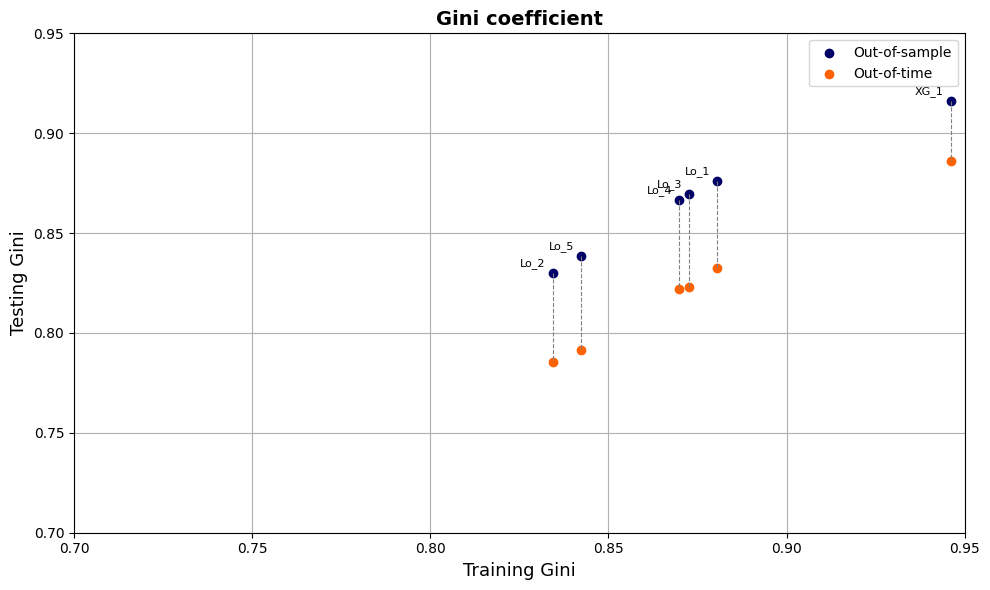

In [43]:
plt.figure(figsize=(10, 6))

# In-time testing Gini
plt.scatter(results_final['In_Time_Train_Gini'], results_final['In_Time_Test_Gini'], color='#000066', label='Out-of-sample')

# Out-of-time testing Gini
plt.scatter(results_final['In_Time_Train_Gini'], results_final['Out_of_Time_Test_Gini'], color='#ff6200', label='Out-of-time')

# Add lollipop lines
for index, row in results_final.iterrows():
    plt.plot([row['In_Time_Train_Gini'], row['In_Time_Train_Gini']], [row['In_Time_Test_Gini'], row['Out_of_Time_Test_Gini']], color='gray', linestyle='--', linewidth=0.8)
    plt.text(row['In_Time_Train_Gini'] - 0.002, row['In_Time_Test_Gini'] + 0.002, row['Model_Name'], ha='right', va='bottom', fontsize=8)

# Add labels and legend
plt.xlabel('Training Gini', fontsize=13)
plt.ylabel('Testing Gini', fontsize=13)
plt.title('Gini coefficient', fontsize=14, fontweight='bold')
plt.legend()

# Set limits for x and y axes
plt.xlim(0.7, 0.95)
plt.ylim(0.7, 0.95)

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

## Shapley value

In [64]:
import shap
from sklearn.model_selection import train_test_split

def model_to_shapley(df, model, target='default', time=2021):
    in_time_df = df[df['year'] < time]
    out_of_time_df = df[df['year'] >= time]

    X_in_time = in_time_df.drop(columns=[target, 'year'])  # Exclude 'year' from features
    y_in_time = in_time_df[target]

    X_out_of_time = out_of_time_df.drop(columns=[target, 'year'])  # Exclude 'year' from features
    y_out_of_time = out_of_time_df[target]

    # Divide in-time data into train and test sets
    X_in_time_train, X_in_time_test, y_in_time_train, y_in_time_test = train_test_split(
        X_in_time, y_in_time, test_size=0.3, stratify=y_in_time, random_state=42)
    
    # Fit the model
    model.fit(X_in_time_train, y_in_time_train)

    # Create a Linear explainer and calculate Shapley values
    explainer = shap.LinearExplainer(model, X_in_time_train, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_out_of_time)

    # Extract feature names
    feature_names = X_out_of_time.columns.tolist()

    # Generate a SHAP summary plot for the out-of-time data
    shap.summary_plot(shap_values, X_out_of_time, feature_names=feature_names)

/Users/kacpergruca/Library/Python/3.11/lib/python/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


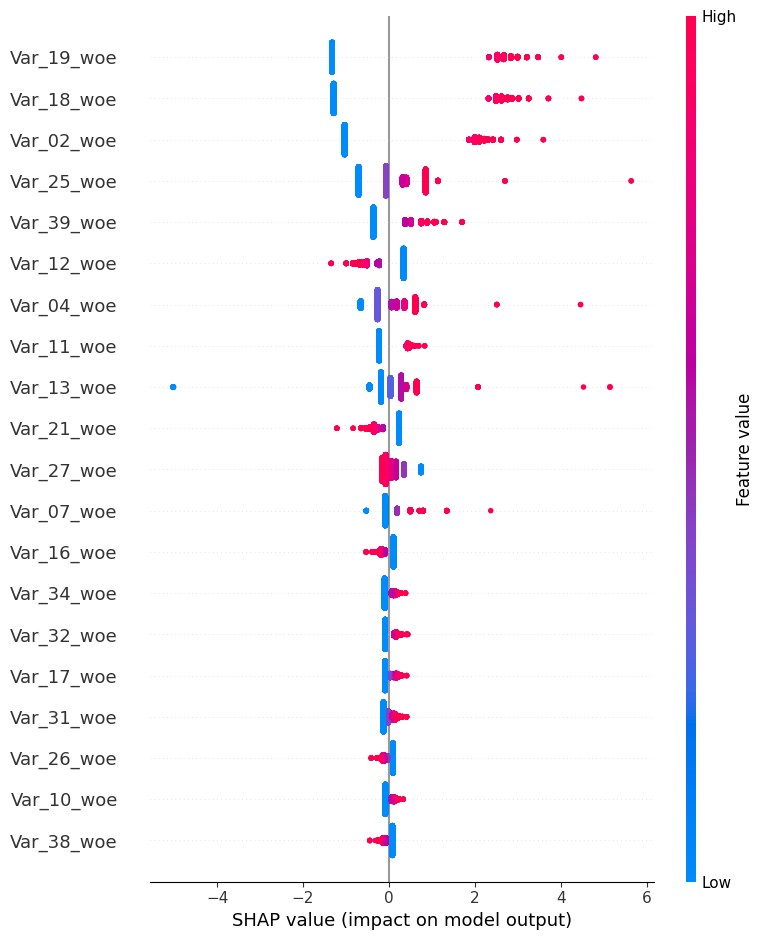

In [65]:
model_config = results_vif_LR.iloc[0,0]

model_to_shapley(df_woe, model_config)